In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from npeet.entropy_estimators import midd

Compare 3 metrics applied to sparse poisson spike trains:
1. Pearson's correlation coefficient
2. Mutual Information
3. Treat score

The latter quantifies the coincidence rate excluding true negatives, thus correcting for sparsity in data. It is defined as follows:

$$TS = \frac{TP}{TP + FP + FN}$$

This metric is biased, as it is consistently non-zero for otherwise uncorrelated signals. The bias for this metric can be computed as follows:

$$
\begin{eqnarray}
\langle TS \rangle_{chance}
&=& \langle \frac{TP}{TP + FP + FN} \rangle \\
&\approx& \frac{\langle TP \rangle}{\langle TP \rangle + \langle FP \rangle + \langle FN \rangle} \\
&=& \frac{N p_A p_B}{N p_A p_B + N p_A (1 - p_B) + N (1 - p_A) p_B} \\
&=& \frac{1}{\frac{1}{p_A} + \frac{1}{p_B} - 1}
\end{eqnarray}
$$

where $p_A$ and $p_B$ are the empirical probabilities for neurons $A$ and $B$ to spike

**TODO**: Bias calculation is inaccurate. By adding extra true negatives, the TS should not change, but bias seems to change, because $p_A$ and $p_B$ depend on it

In [33]:
corr = lambda x,y: np.corrcoef(x,y)[0,1]
miEff = lambda x,y: midd(x[:, None], y[:, None])

def tsEff(x, y):
    # Compute original metric
    nTP = np.sum(x & y)
    nFP = np.sum(x & ~y)
    nFN = np.sum(~x & y)
    rez = nTP / (nTP + nFP + nFN)
    return rez
    
#     # Compute bias
#     n = x.shape[0]
#     nX = np.sum(x)
#     nY = np.sum(y)
#     pX = nX / n
#     pY = nY / n
#     bias = 1 / (1 / pX + 1 / pY - 1)
#     return rez - bias
    
#     nPrim = nTP + nFP + nFN
#     pX = np.sum(x) / nPrim
#     pY = np.sum(y) / nPrim
#     bias = 1 / (1 / pX + 1 / pY - 1)
#     return rez - bias

## Test 1: Does Corr noise depend on sparsity in spikes

Results:
* Corr: No
* MI: No

In [34]:
methodDict = {
    'corr' : corr,
    'miEff' : miEff,
    'tsEff' : tsEff
}

/opt/anaconda3/envs/py3ml/lib/python3.8/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


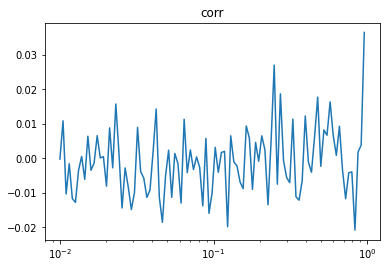

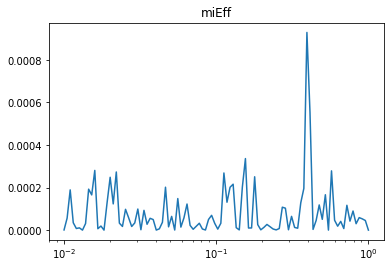

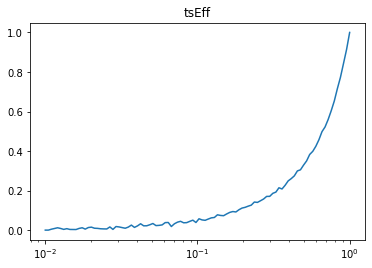

In [35]:
def noise_sparsity_test(method, methodName, nTest=20, nSample=10000):
    pArr = 10 ** np.linspace(-2, 0, nTest)

    rezLst = []
    for p in pArr:
        a = (np.random.uniform(0, 1, nSample) < p).astype(int)
        b = (np.random.uniform(0, 1, nSample) < p).astype(int)

        rezLst += [method(a, b)]

    plt.figure()
    plt.semilogx(pArr, rezLst)
    plt.title(methodName)
    plt.show()
    
for methodName, method in methodDict.items():
    noise_sparsity_test(method, methodName, nTest=100)

## Test 2: Does Corr effect size depend on added sparsity


Result
* Corr: Yes, inflates artificially with increased sparsity
* MI: Yes, deflates artificially
    - Why deflates?
    - Why continuous estimator oscillates so much?

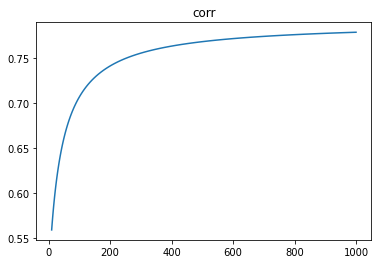

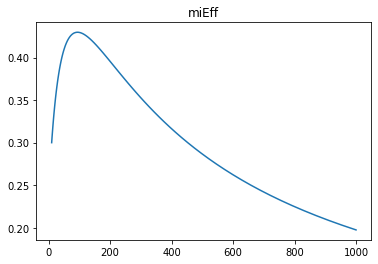

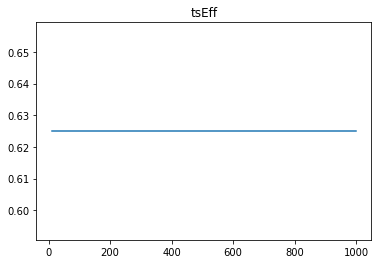

In [36]:
def effect_sparsity_test(method, methodName, nTest=100):
    a = [1] * 80 + [0] * 20
    b = [1] * 50 + [0] * 50

    nExtraLst = (10**np.linspace(1, 3, nTest)).astype(int)

    rezLst = []
    for iExtra in nExtraLst:
        rezLst += [method(np.array(a + [0]*iExtra), np.array(b + [0]*iExtra))]

    plt.figure()
    plt.plot(nExtraLst, rezLst)
    plt.title(methodName)
    plt.show()
    
for methodName, method in methodDict.items():
    effect_sparsity_test(method, methodName, nTest=100)

## Test 3: Does noise Corr depend on frequency ratio

Result:
* Corr: No
* Mi: No

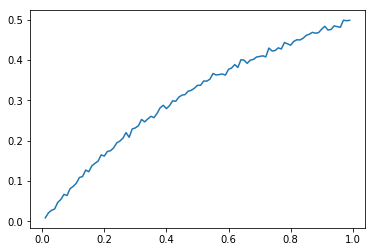

In [51]:
def noise_rate_test(method):
    pArr = np.arange(1, 100)/100

    rezLst = []
    for p in pArr:
        a = (np.random.uniform(0,1,10000) < 0.5).astype(int)
        b = (np.random.uniform(0,1,10000) < p).astype(int)
        rezLst += [method(a, b)]

    plt.figure()
    plt.plot(pArr, rezLst)
    plt.show()
    
# noise_rate_test(corr)
# noise_rate_test(midd)
noise_rate_test(accEff)